# Tutorial on how to fit emission line and use IFU data - KMOS/SINFONI/JWST etc

Here I am going to go through basic of analysing IFU data and fitting emission lines. First, in order to quickly look at IFU cubes, I recommend QFits. https://www.mpe.mpg.de/~ott/QFitsView/. 

To read more about Integral Field Spectroscopy, I recommend section 2.2 of my thesis: http://etheses.dur.ac.uk/13311/1/Thesis_cor_mk_II.pdf?DDD25+ or from Chris Harrison; Chapter 2. http://etheses.dur.ac.uk/10744/1/cmh_thesis.pdf?DDD25+


# Dealing wih IFU data

We will first start with loading the cube and extracting a spectrum. We will then continue to write a simple fitting code to fit the spectrum from the previous tutorial. 

Lets start with importing basic libraries. This is a start of every code I write. 

In [10]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy.optimize import curve_fit

import emcee
import corner 

from os.path import exists
nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23



PATH='/Users/jansen/My Drive/Astro/'


## Loading the JWST IFS cube. 

We will now load the IFU cube and extract all of the import information. We need to extract the wavelength grid and the data cube and the header information. 

In [14]:
path = '/Users/jansen/JADES/GA_NIFS/IFS_data_v1/' 
file_name = '5001-GS-3.47-S_jw1216_o005_ff_px0.05_drizzle_ODfde98_3_VSC_MRC_MSA_m2ff_CTX1068.pmap_v1.8.2_g235h-f170lp_cgs_s3d.fits' # Full path to the file

Full_path = path + file_name

with pyfits.open(Full_path, memmap=False) as hdulist:

    Flux_cube = hdulist['SCI'].data *1e4 * 1e15
    Header = hdulist['SCI'].header

    n_channels = Header['NAXIS3'] # Extract the number pixels in the third axis (wavelength)
    obs_wave = Header['CRVAL3'] + (np.arange(n_channels) - (Header['CRPIX3'] - 1.0))*Header['CDELT3'] # Extract the wavelength grid


print('The shape of the data cube is as follows', Flux_cube.shape)
z = 3.472

plt.show()


The shape of the data cube is as follows (3811, 97, 89)


## Extracting a single spaxel spectrum

When we looked in QFitsView we could see the individual spaxel spectrum. In python we can to this with simple indexing the right part of the Flux_cube array and also plot it. 

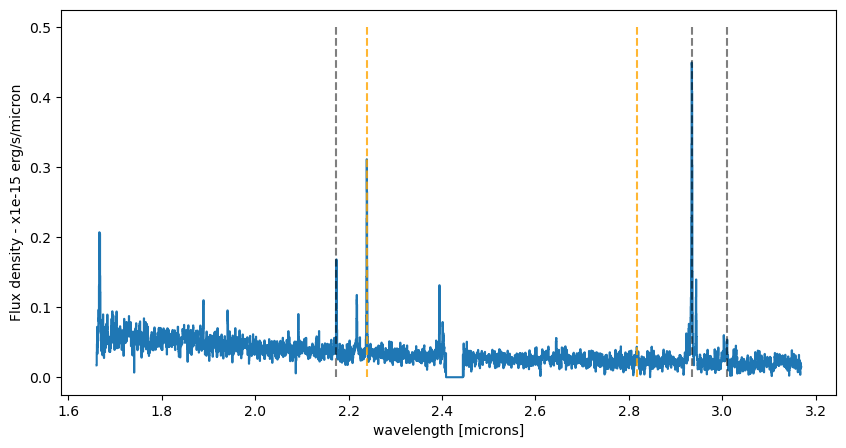

In [15]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 43,51 # Coordinates of the spaxel we want to extract the spectrum from
Flux_spaxel = Flux_cube[:, y,x] # Extract the spectrum of the spaxel at position (x,y)
ax.plot( obs_wave, Flux_spaxel, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')



ylow = -0.
yhig = 0.5

ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)
ax.vlines(0.6300*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)


ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)


ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)


plt.show()

We can also zoom in on th [OIII] + Hbeta emission lines, just simply using the ax.set_xlim()

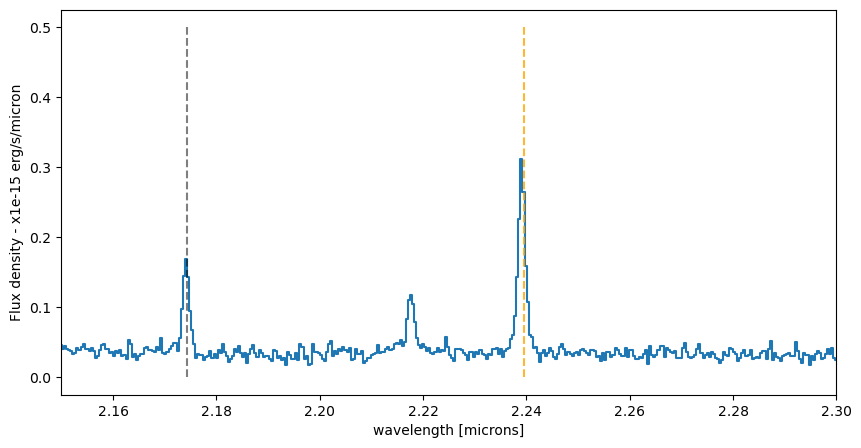

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 43,51  # Coordinates of the spaxel we want to extract the spectrum from
Flux_spaxel = Flux_cube[:, y,x] # Extract the spectrum of the spaxel at position (x,y)
ax.plot( obs_wave, Flux_spaxel, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 0.5

ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)
ax.vlines(0.6300*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4862*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.set_xlim(2.15,2.3)

plt.show()

or we can look at the Halpha + [NII] + [SII]

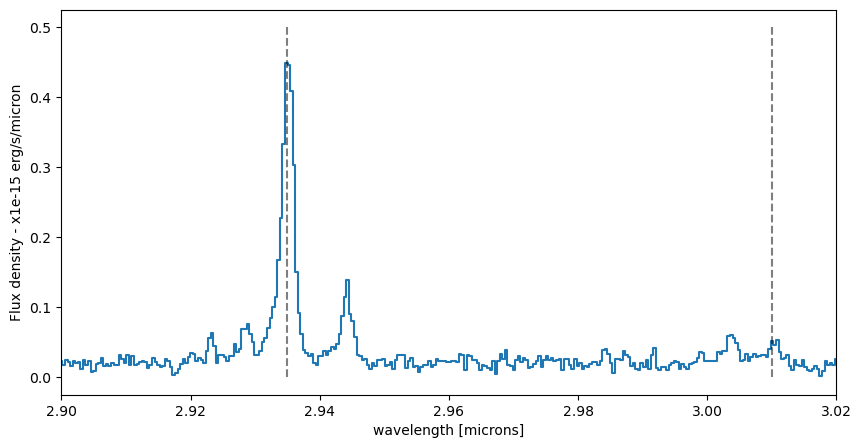

In [24]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 43,51  # Coordinates of the spaxel we want to extract the spectrum from
Flux_spaxel = Flux_cube[:, y,x] # Extract the spectrum of the spaxel at position (x,y)
ax.plot( obs_wave, Flux_spaxel, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 0.5

ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)
ax.vlines(0.6300*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.set_xlim(2.9,3.02)

plt.show()

## Extracting a spectrum from multiple spaxel together - circular aperture 

The best thing about IFS is that we extract spectrum from anywhere in the galaxy to investigate the properties in that section. We can use a very simple circular mask to setup to create a spectrum with a sum of all of the spaxels. 

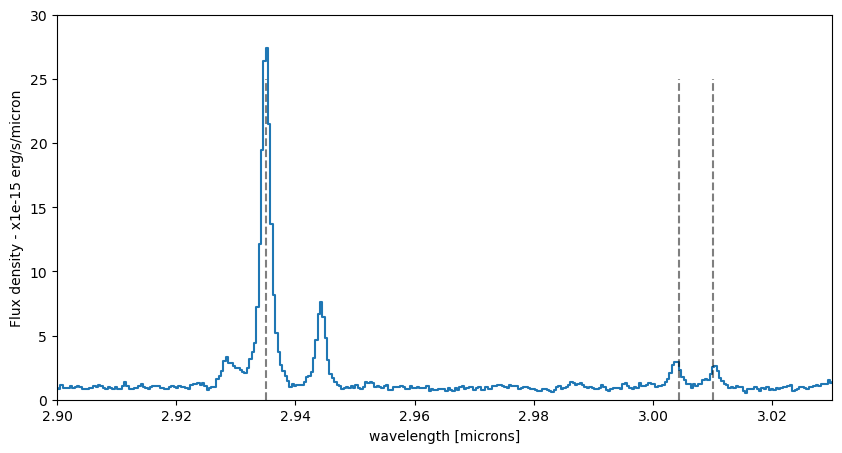

In [25]:
def sp_circ_ap(cenx,ceny,rad,Flux_cube):

    nwl = len(Flux_cube[:,0,0])
    nx = len(Flux_cube[0,0,:])
    ny = len(Flux_cube[0,:,0])
    nwl, ny, nx = Flux_cube.shape
    # creates array with one spectrum per row
    intermarray = np.full((nwl,nx*ny), np.nan)
    # fills it with nans
    
    nloop = 0
    # loop on data
    for x in range(nx) :
        for y in range(ny) :  
            distance = np.sqrt((x-cenx)**2+(y-ceny)**2)
            if distance < rad :
                intermarray[:,int(nloop)] = Flux_cube[:,int(y),int(x)]
                nloop += 1
               
    # average
    outspec = np.nansum(intermarray,axis=1)
    return outspec

# This function extracts the spectrum from a circular aperture of radius 5 pixels centered on the sp
D1_spec = sp_circ_ap(44,47,5,Flux_cube) # 5 pixel radius aperture centered on the spaxel at (44,47)

D1_spec = np.ma.masked_invalid(D1_spec ) # Mask invalid values (nans, infs etc.)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 44,47 # Coordinates of the spaxel we want to extract the spectrum from
ax.plot( obs_wave, D1_spec, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 25

ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)
ax.vlines(0.6300*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.6718*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.set_xlim(2.9,3.03)
ax.set_ylim(-0.,30.)

plt.show()

# Create a emission line map

We can also create a very simple linemap similar to what way we did it in QFitsView. This way we can actually visualize the emission lines and they spatial extent.

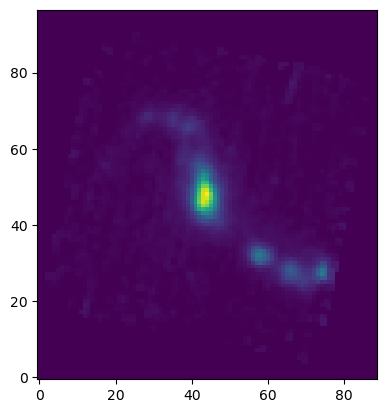

In [ ]:
# Creating the linemap:

from QubeSpec import Cube


channel0, channel1 = 3213, 3225 # Values from QFitsView from around Halpha emission line

# Creating a linemap:
Linemap = np.sum(Flux_cube[channel0:channel1, :,:], axis=(0))

# and now plot
f, ax = plt.subplots(1)

ax.imshow(Linemap, cmap='viridis', vmin=0, origin='lower')

plt.show()

## [OIII]

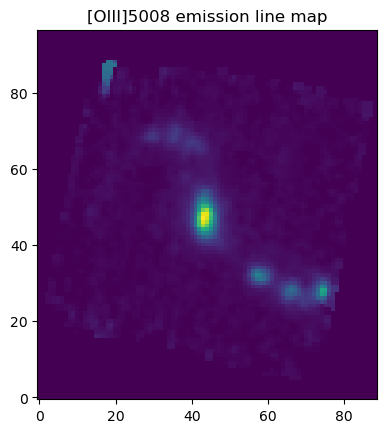

In [36]:
# Creating the linemap:

from QubeSpec import Cube


channel0, channel1 = 1456, 1468 # Values from QFitsView from around Halpha emission line

# Creating a linemap:
Linemap = np.sum(Flux_cube[channel0:channel1, :,:], axis=(0))*(obs_wave[1]-obs_wave[0])

# and now plot
f, ax = plt.subplots(1)

ax.imshow(Linemap, cmap='viridis', vmin=0, origin='lower')

ax.set_title('[OIII]5008 emission line map')
plt.show()

# Different emission line regions:
## Main

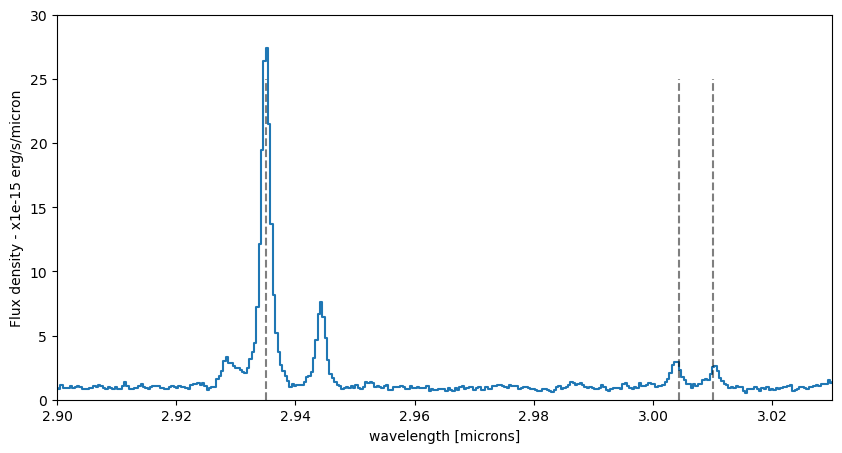

In [ ]:
# This function extracts the spectrum from a circular aperture of radius 5 pixels centered on the sp
D1_spec = sp_circ_ap(44,47,7,Flux_cube) # 5 pixel radius aperture centered on the spaxel at (44,47)

D1_spec = np.ma.masked_invalid(D1_spec ) # Mask invalid values (nans, infs etc.)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 44,47 # Coordinates of the spaxel we want to extract the spectrum from
ax.plot( obs_wave, D1_spec, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 25

ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.6718*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.set_xlim(2.9,3.03)
ax.set_ylim(-0.,30.)

plt.show()

## South East

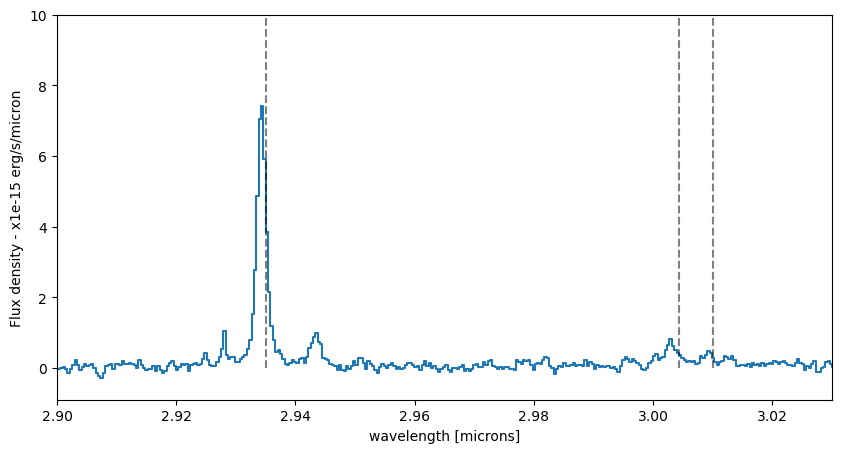

In [32]:
# This function extracts the spectrum from a circular aperture of radius 5 pixels centered on the sp
D1_spec = sp_circ_ap(58,32,4,Flux_cube) # 5 pixel radius aperture centered on the spaxel at (44,47)

D1_spec = np.ma.masked_invalid(D1_spec ) # Mask invalid values (nans, infs etc.)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 44,47 # Coordinates of the spaxel we want to extract the spectrum from
ax.plot( obs_wave, D1_spec, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 25

ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.6718*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.set_xlim(2.9,3.03)
ax.set_ylim(-0.9,10.)

plt.show()

## South center

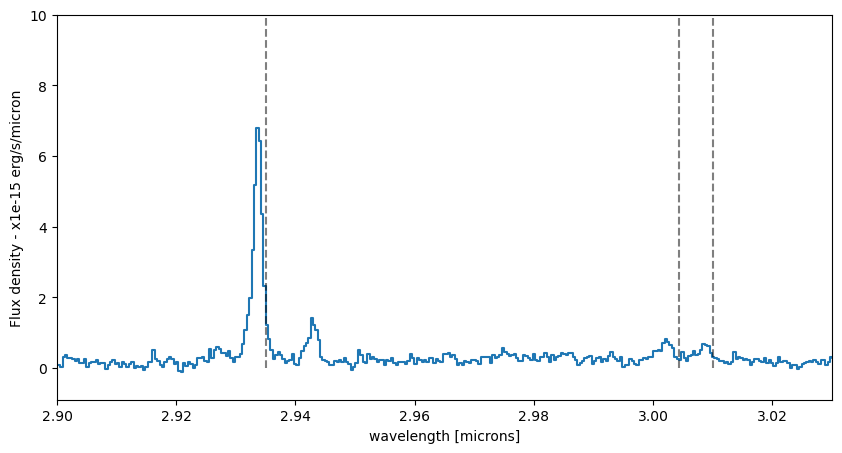

In [33]:
# This function extracts the spectrum from a circular aperture of radius 5 pixels centered on the sp
D1_spec = sp_circ_ap(66,28,4,Flux_cube) # 5 pixel radius aperture centered on the spaxel at (44,47)

D1_spec = np.ma.masked_invalid(D1_spec ) # Mask invalid values (nans, infs etc.)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 44,47 # Coordinates of the spaxel we want to extract the spectrum from
ax.plot( obs_wave, D1_spec, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 25

ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.6718*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.set_xlim(2.9,3.03)
ax.set_ylim(-0.9,10.)

plt.show()

## South West

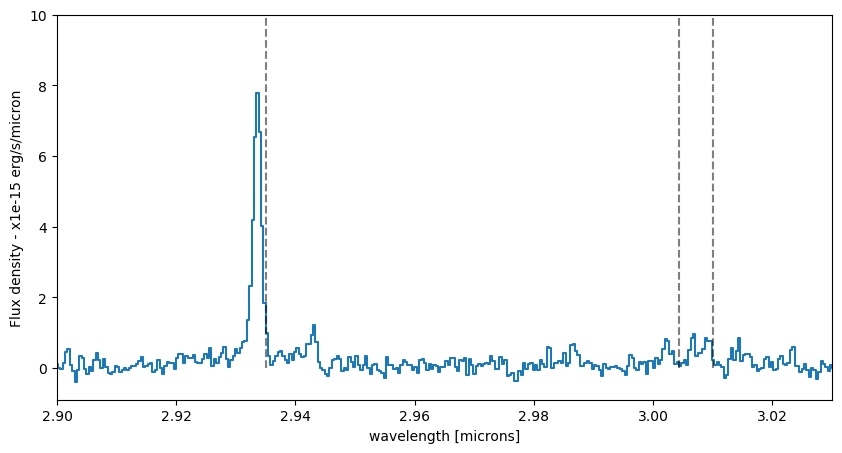

In [35]:
# This function extracts the spectrum from a circular aperture of radius 5 pixels centered on the sp
D1_spec = sp_circ_ap(74,28,4,Flux_cube) # 5 pixel radius aperture centered on the spaxel at (44,47)

D1_spec = np.ma.masked_invalid(D1_spec ) # Mask invalid values (nans, infs etc.)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 44,47 # Coordinates of the spaxel we want to extract the spectrum from
ax.plot( obs_wave, D1_spec, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 25

ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.6718*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.set_xlim(2.9,3.03)
ax.set_ylim(-0.9,10.)

plt.show()